# Проект "Дашборд конверсий"

In [1]:
import pandas as pd
import numpy as np
import requests
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [3]:
rsp_visits = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
visits_data = rsp_visits.json()
visits_df = pd.DataFrame(visits_data)

# Исключение ботов
visits_df = visits_df[visits_df['user_agent'] != 'bots']

# Оставляем только последний визит пользователя
visits_df['datetime'] = pd.to_datetime(visits_df['datetime'])
visits_df = visits_df.sort_values(by=['datetime']).drop_duplicates(subset=['visit_id'], keep='last')

rsp_regs = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
data_regs = rsp_regs.json()
regs_df = pd.DataFrame(data_regs)

regs_df['datetime'] = pd.to_datetime(regs_df['datetime'])
regs_df['date_group'] = regs_df['datetime'].dt.date
visits_df['date_group'] = visits_df['datetime'].dt.date

regs_grouped = regs_df.groupby(['date_group', 'platform']).size().reset_index(name='registrations')
visits_grouped = visits_df.groupby(['date_group', 'platform']).size().reset_index(name='visits')

regs_grouped['date_group'] = pd.to_datetime(regs_grouped['date_group'])
visits_grouped['date_group'] = pd.to_datetime(visits_grouped['date_group'])

# Объединение данных с inner join
merged_df = pd.merge(regs_grouped, visits_grouped, on=['date_group', 'platform'], how='inner')

# Приведение типов
merged_df['registrations'] = merged_df['registrations'].astype(int)
merged_df['visits'] = merged_df['visits'].astype(int)

# Расчет conversion без округления
merged_df['conversion'] = np.where(
    merged_df['visits'] == 0, 0, 
    merged_df['registrations'] / merged_df['visits'] * 100
)

# Упорядочивание колонок
merged_df = merged_df[['date_group', 'platform', 'visits', 'registrations', 'conversion']]

# Сохранение JSON
merged_df.to_json('./conversion.json')

In [4]:
ads_df = pd.read_csv('ads.csv')
ads_df['date'] = pd.to_datetime(ads_df['date'])
ads_df['date_group'] = ads_df['date'].dt.date

In [5]:
ads_grouped = ads_df.groupby(['date_group', 'utm_campaign'])['cost'].sum().reset_index()
ads_grouped['date_group'] = pd.to_datetime(ads_grouped['date_group'])
merged_df['date_group'] = pd.to_datetime(merged_df['date_group'], unit='ms')

In [6]:
result_df = pd.merge(merged_df, ads_grouped, on='date_group', how='left')
result_df.fillna({'cost': 0, 'utm_campaign': 'none'}, inplace=True)
result_df.to_json('ads.json', orient='records')

## Визуализация

In [7]:
import os

chart_dir = 'charts'
if not os.path.exists(chart_dir):
    os.makedirs(chart_dir)

In [8]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.cm as cm
import seaborn as sns

In [9]:
result_df['date_group'] = pd.to_datetime(result_df['date_group'], unit='ms')
daily_visits = result_df.groupby('date_group')['visits'].sum().reset_index()
#filtered_df = result_df[(result_df['date_group'] >= '2023-01-01') & (result_df['date_group'] <= '2023-09-01')]

### Итоговые визиты

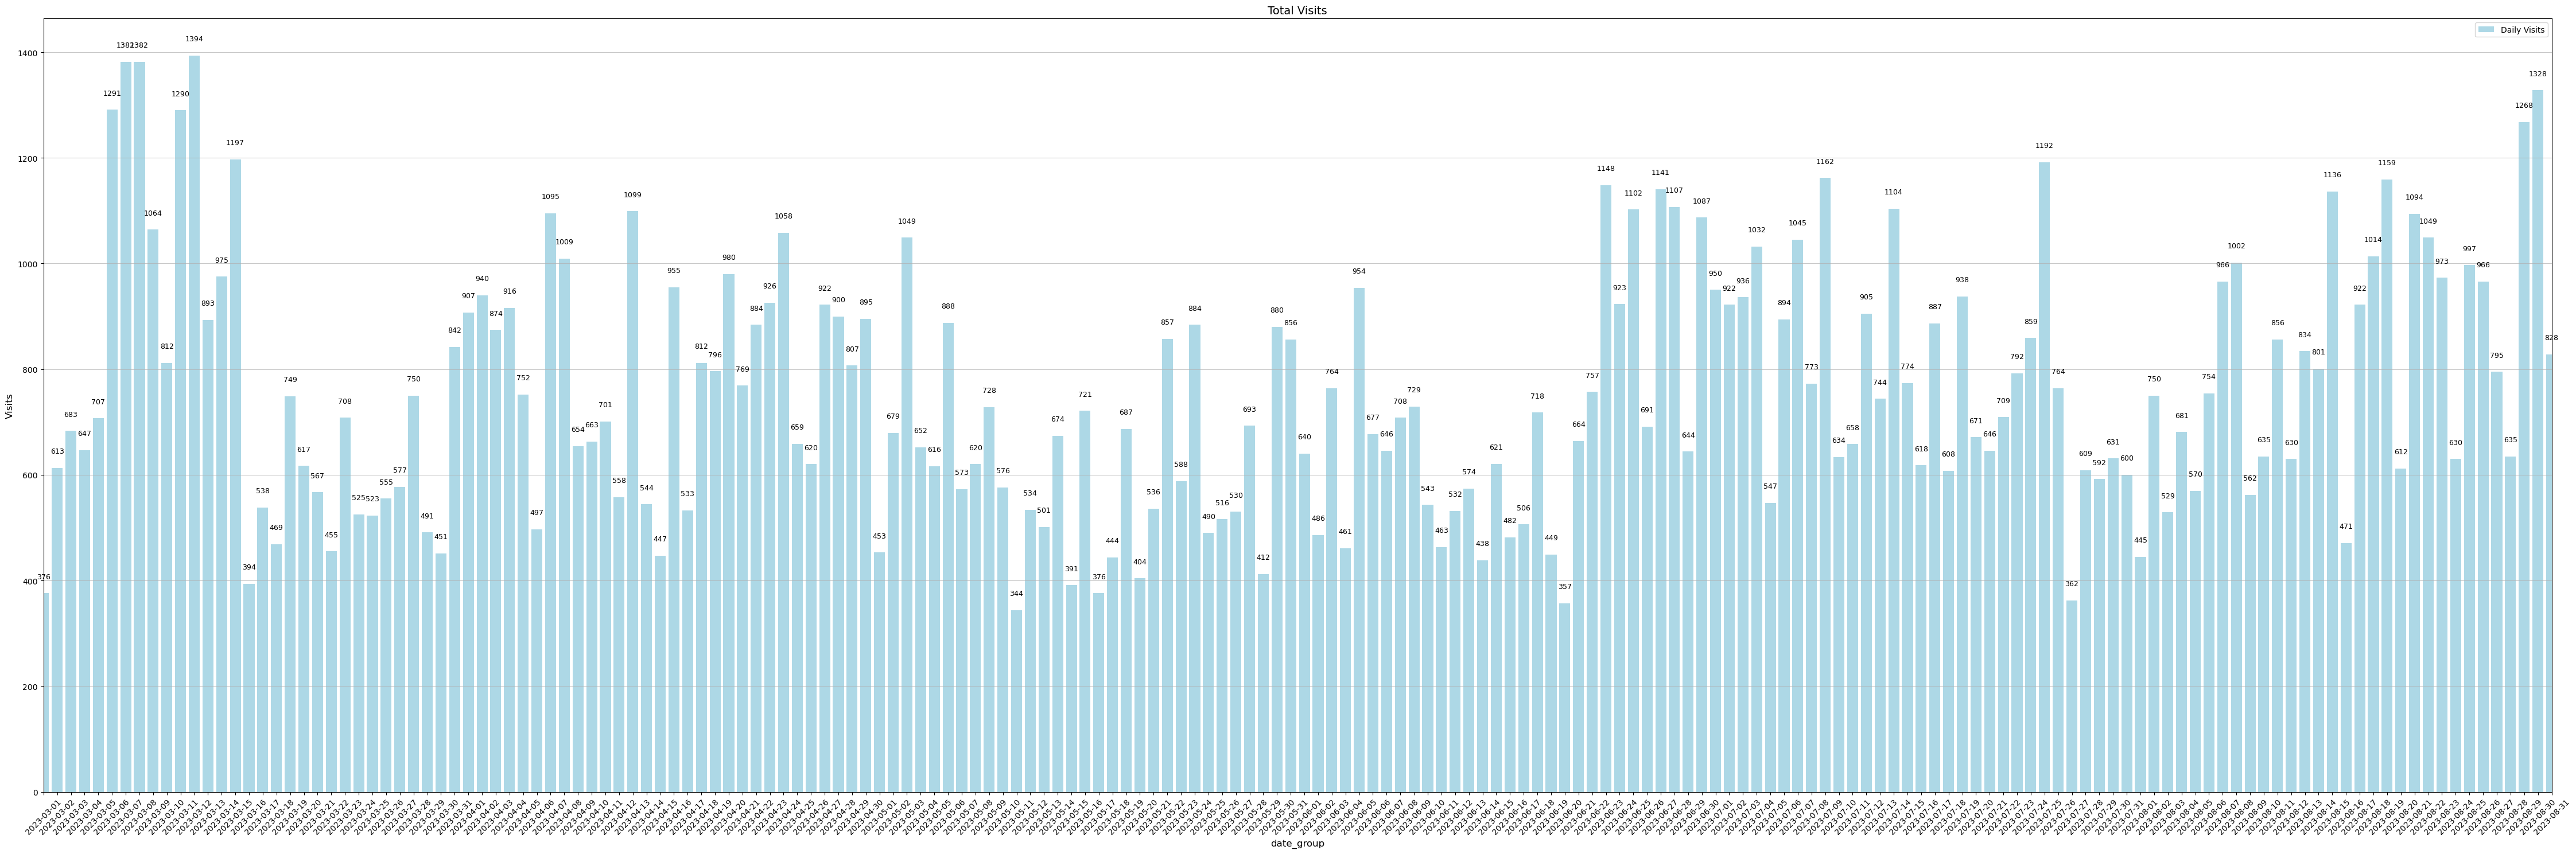

In [10]:
#daily_visits = filtered_df.groupby('date_group')['visits'].sum().reset_index()

plt.figure(figsize=(45, 15))
plt.bar(daily_visits['date_group'], daily_visits['visits'], color='lightblue', label='Daily Visits')

plt.title('Total Visits', fontsize=14)
plt.xlabel('date_group', fontsize=12)
plt.ylabel('Visits', fontsize=12)
plt.xticks(daily_visits['date_group'], rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.legend(fontsize=10)

plt.xlim(daily_visits['date_group'].iloc[0], daily_visits['date_group'].iloc[-1])

for x, y in zip(daily_visits['date_group'], daily_visits['visits']):
    plt.text(x, y + 0.02 * max(daily_visits['visits']), str(y), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./charts/total_visits.png', dpi=300, bbox_inches='tight')
plt.show()

### Итоговые визиты с разбивкой по платформам: web, android, ios

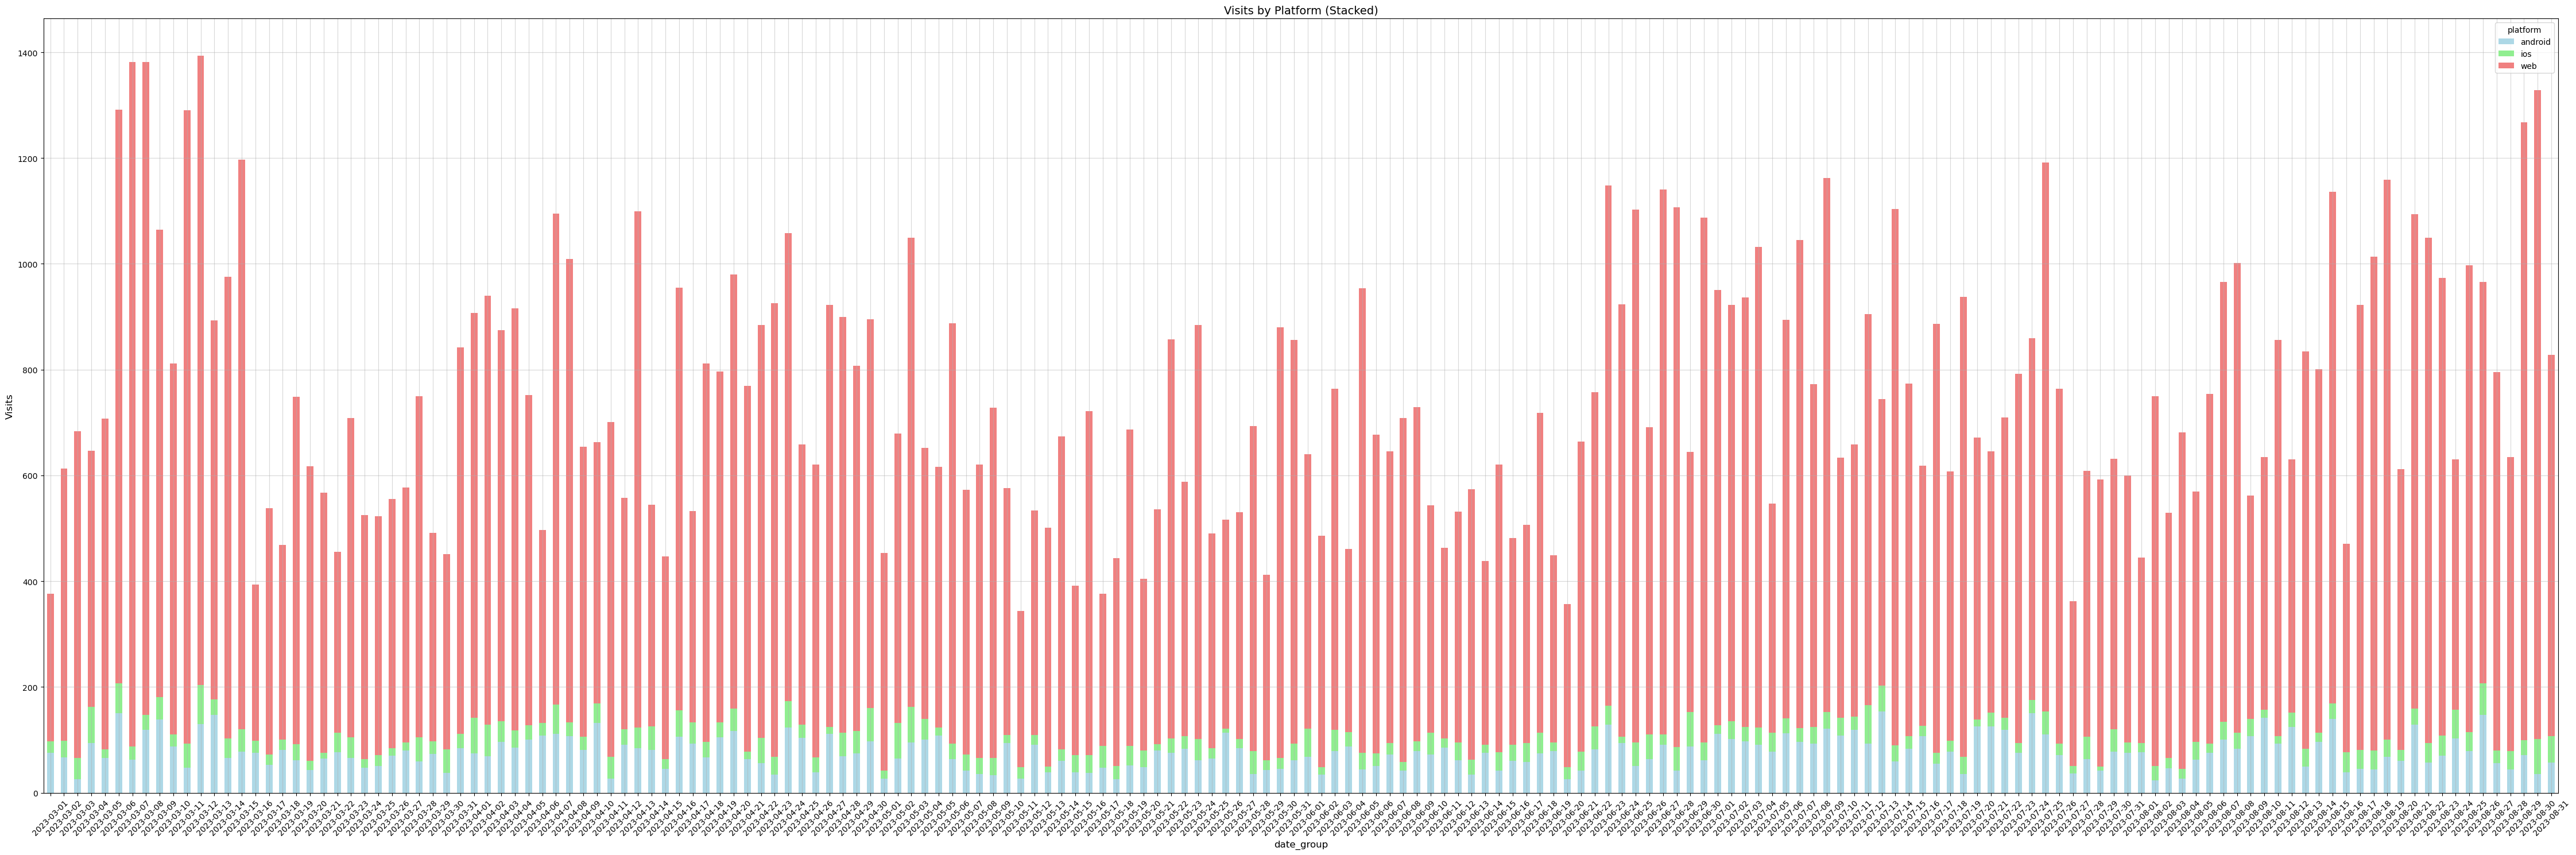

In [11]:
result_df_no_bot = result_df[result_df['platform'] != 'bot']

platform_visits_no_bot = result_df_no_bot.groupby(['date_group', 'platform'])['visits'].sum().unstack(fill_value=0)

plt.figure(figsize=(45, 15))

platform_visits_no_bot.plot(kind='bar', stacked=True, color=['lightblue', 'lightgreen', 'lightcoral'], ax=plt.gca())

plt.title('Visits by Platform (Stacked)', fontsize=14)
plt.xlabel('date_group', fontsize=12)
plt.ylabel('Visits', fontsize=12)
plt.xticks(ticks=range(len(platform_visits_no_bot.index)), labels=platform_visits_no_bot.index.date, rotation=45, fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.grid(axis='x', linestyle='-', alpha=0.5)

plt.legend(title='platform', fontsize=10)

plt.tight_layout()
plt.savefig('./charts/visits_by_platform.png', dpi=300, bbox_inches='tight')
plt.show()

### Итоговые регистрации

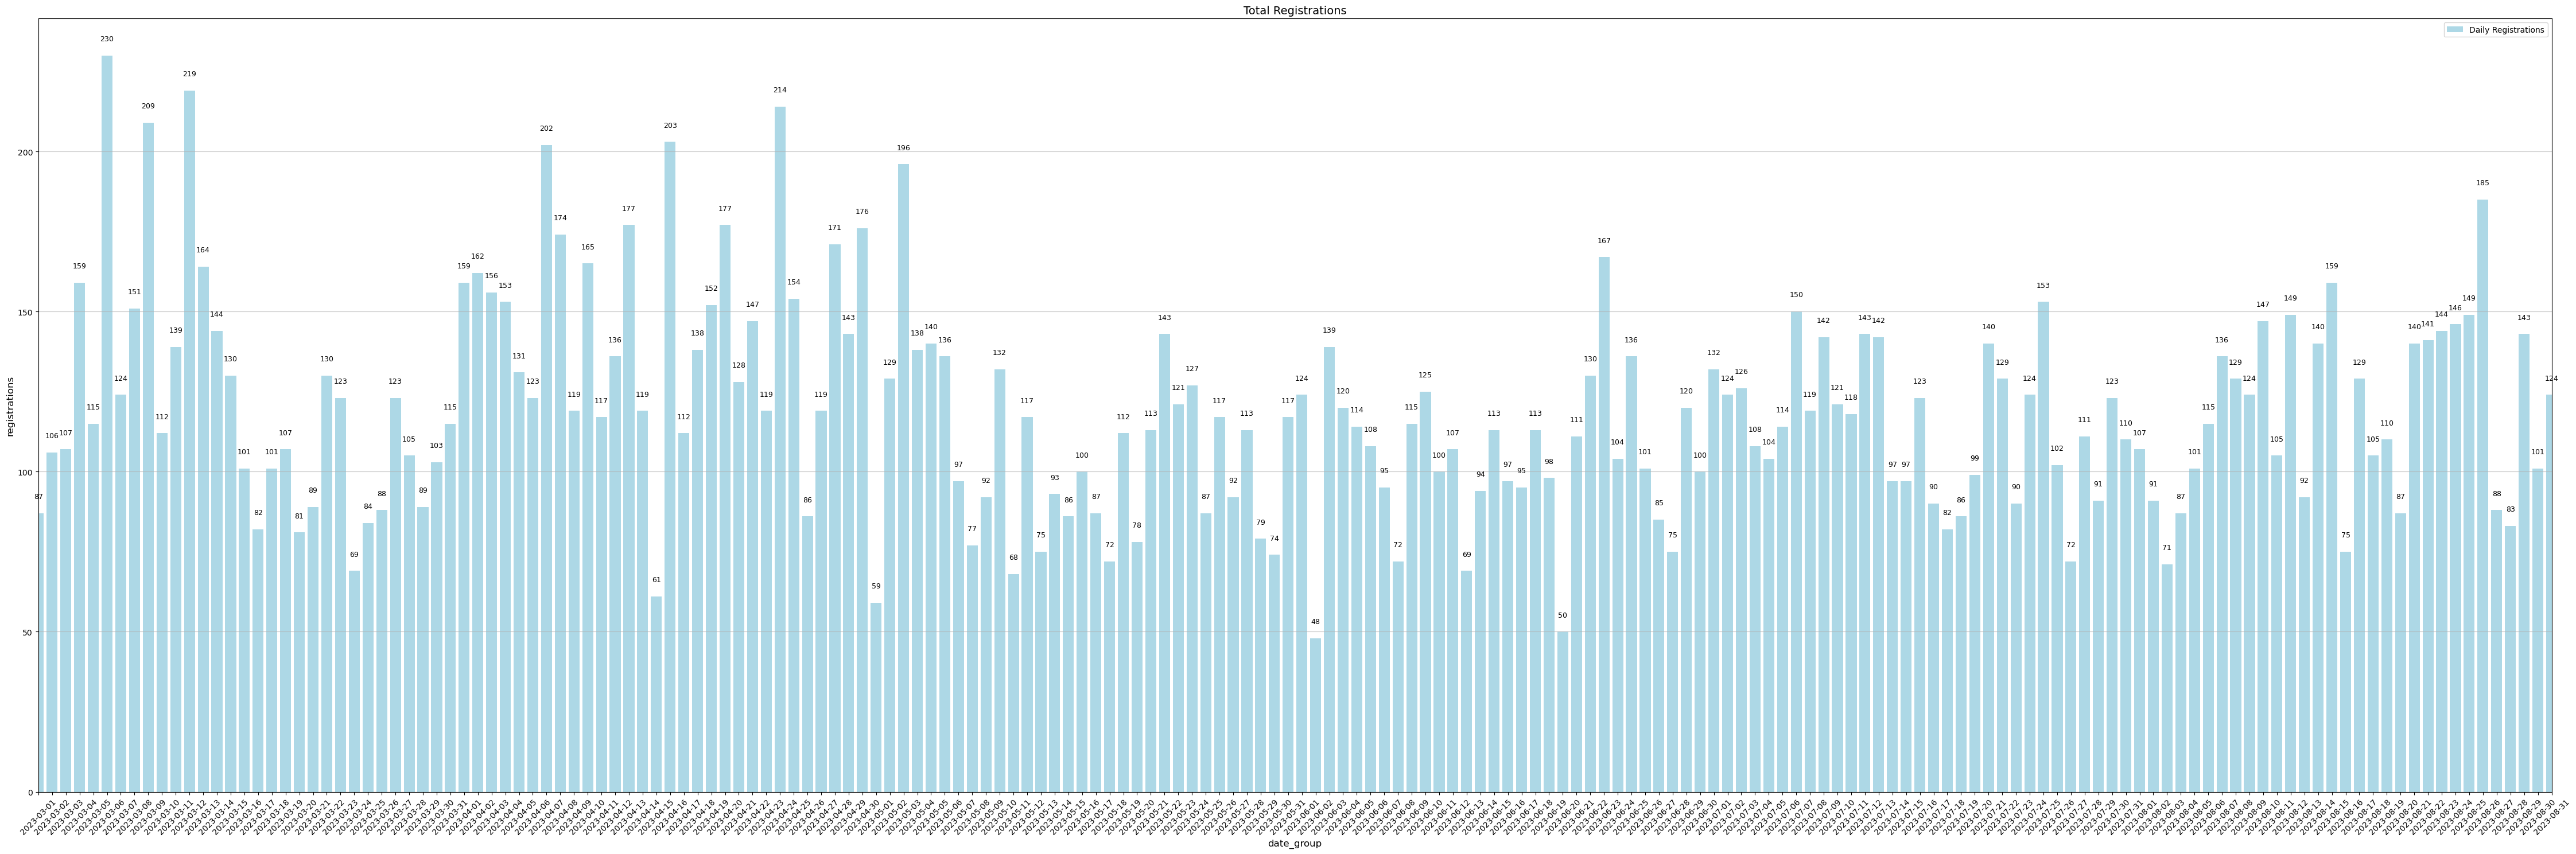

In [12]:
daily_visits = result_df.groupby('date_group')['registrations'].sum().reset_index()

plt.figure(figsize=(45, 15))
plt.bar(daily_visits['date_group'], daily_visits['registrations'], color='lightblue', label='Daily Registrations')

plt.title('Total Registrations', fontsize=14)
plt.xlabel('date_group', fontsize=12)
plt.ylabel('registrations', fontsize=12)
plt.xticks(daily_visits['date_group'], rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.legend(fontsize=10)

plt.xlim(daily_visits['date_group'].iloc[0], daily_visits['date_group'].iloc[-1])

for x, y in zip(daily_visits['date_group'], daily_visits['registrations']):
    plt.text(x, y + 0.02 * max(daily_visits['registrations']), str(y), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./charts/total_registrations.png', dpi=300, bbox_inches='tight')
plt.show()

### Итоговые регистрации с разбивкой по платформам: web, android, ios

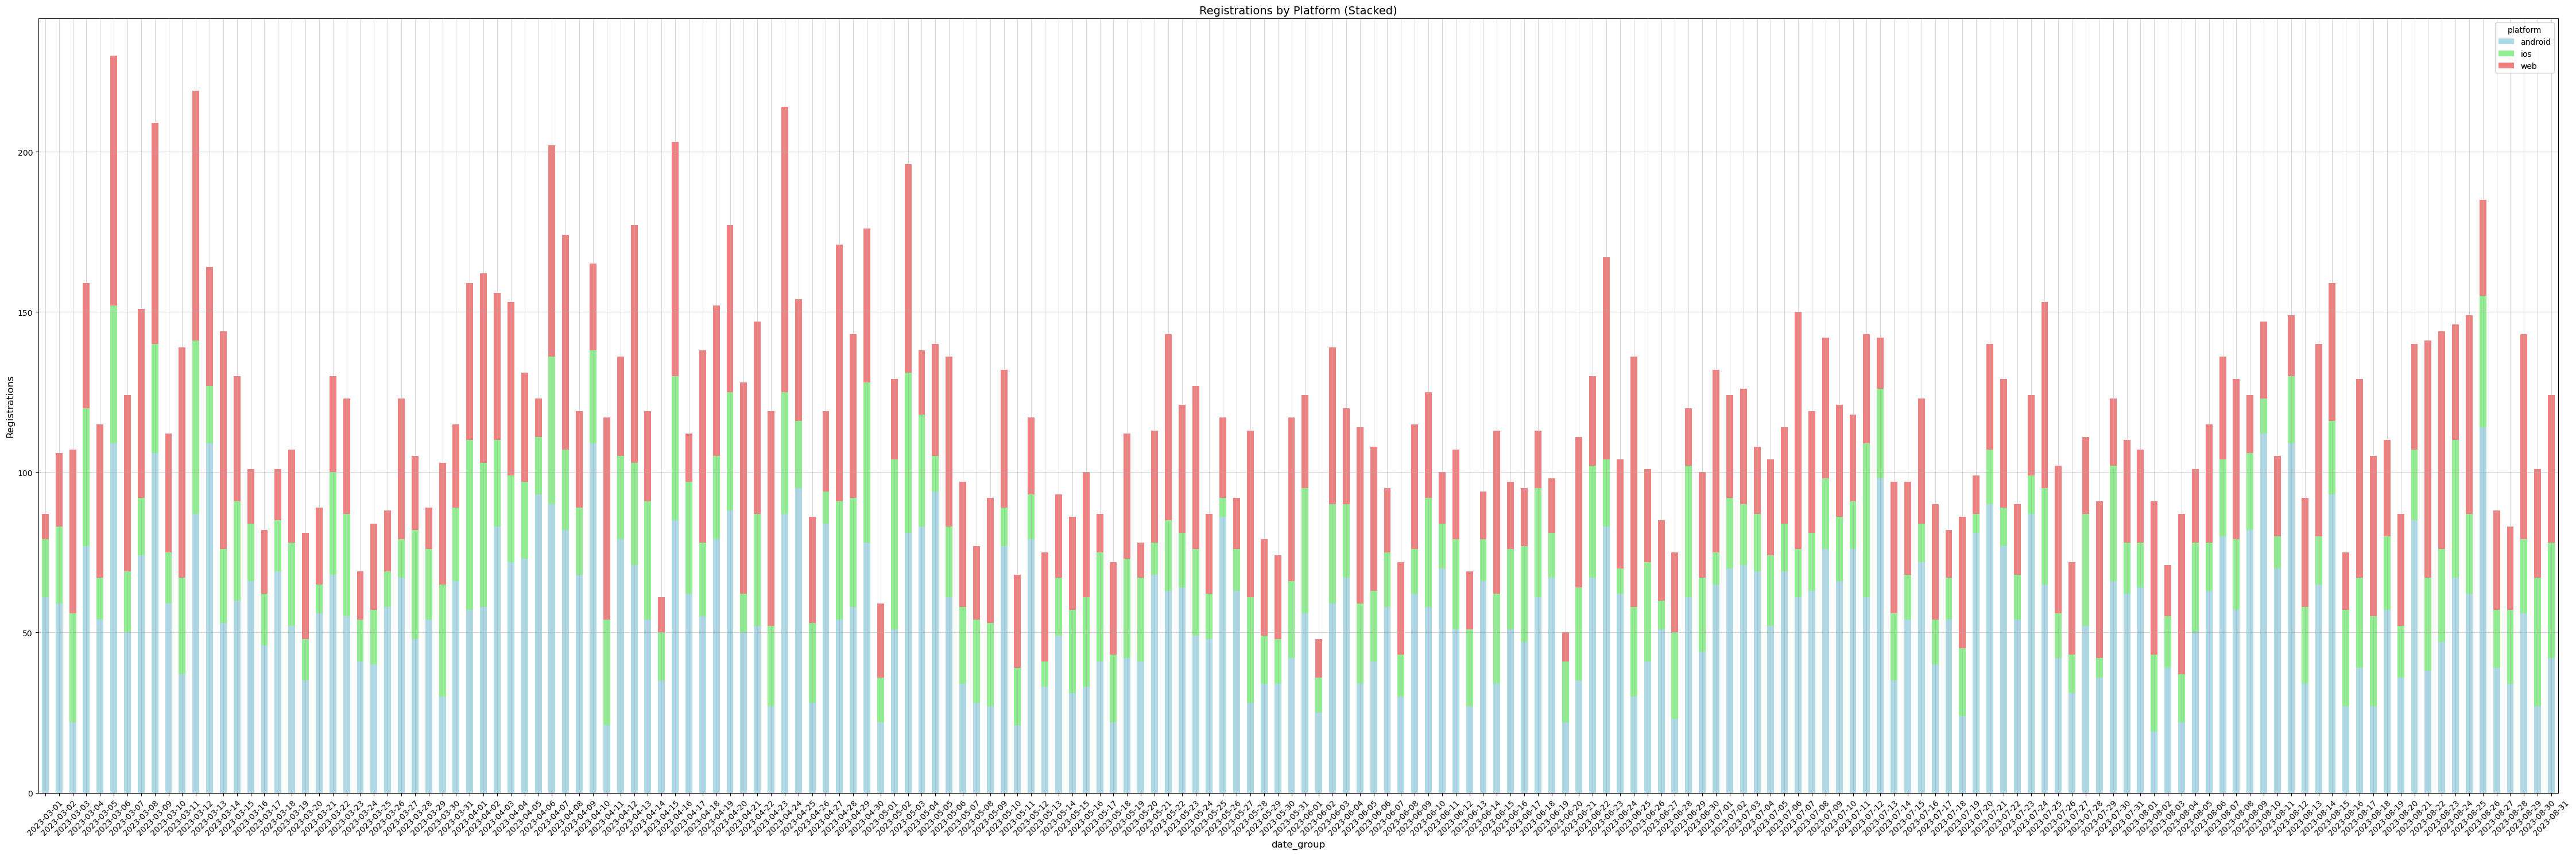

In [13]:
result_df_no_bot = result_df[result_df['platform'] != 'bot']

platform_visits_no_bot = result_df_no_bot.groupby(['date_group', 'platform'])['registrations'].sum().unstack(fill_value=0)

plt.figure(figsize=(45, 15))

platform_visits_no_bot.plot(kind='bar', stacked=True, color=['lightblue', 'lightgreen', 'lightcoral'], ax=plt.gca())

plt.title('Registrations by Platform (Stacked)', fontsize=14)
plt.xlabel('date_group', fontsize=12)
plt.ylabel('Registrations', fontsize=12)
plt.xticks(ticks=range(len(platform_visits_no_bot.index)), labels=platform_visits_no_bot.index.date, rotation=45, fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.grid(axis='x', linestyle='-', alpha=0.5)

plt.legend(title='platform', fontsize=10)

plt.tight_layout()
plt.savefig('./charts/registrations_by_platform.png', dpi=300, bbox_inches='tight')
plt.show()

### Итоговые конверсии

C:\Users\matve\AppData\Local\Temp\ipykernel_10024\4126493414.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df_weekly_no_bot.groupby('date_group').apply(lambda x: x['registrations'].sum() / x['visits'].sum() * 100)


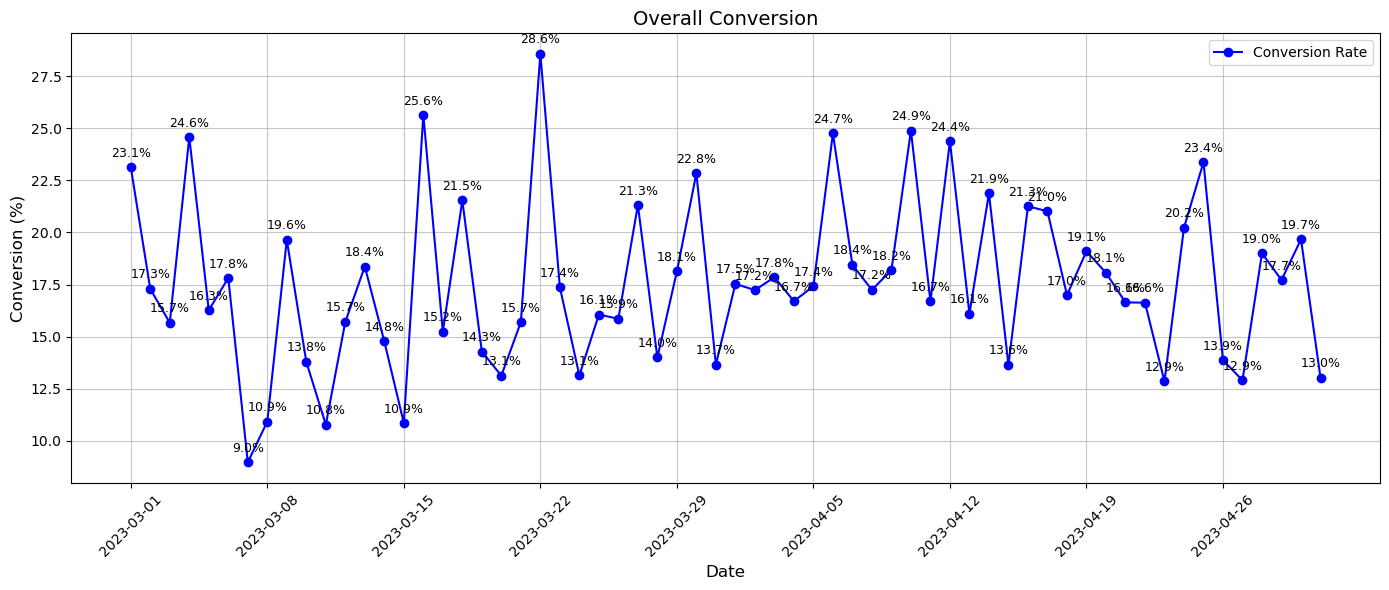

In [14]:
result_df_no_bot = result_df[result_df['platform'] != 'bot']

result_df_weekly_no_bot = result_df_no_bot[(result_df_no_bot['date_group'] >= '2023-03-01') & 
                                             (result_df_no_bot['date_group'] <= '2023-05-01')]

daily_conversion_no_bot = (
    result_df_weekly_no_bot.groupby('date_group').apply(lambda x: x['registrations'].sum() / x['visits'].sum() * 100)
).reset_index(name='conversion_rate')

plt.figure(figsize=(14, 6))

plt.plot(daily_conversion_no_bot['date_group'], daily_conversion_no_bot['conversion_rate'], marker='o', color='blue', label='Conversion Rate')

for x, y in zip(daily_conversion_no_bot['date_group'], daily_conversion_no_bot['conversion_rate']):
    plt.text(x, y + 0.5, f"{y:.1f}%", ha='center', fontsize=9)

weekly_ticks = pd.date_range(start='2023-03-01', end='2023-05-01', freq='7D')

plt.title('Overall Conversion', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Conversion (%)', fontsize=12)
plt.xticks(ticks=weekly_ticks, labels=weekly_ticks.strftime('%Y-%m-%d'), rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='-', alpha=0.7)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('./charts/overall_conversion.png', dpi=300, bbox_inches='tight')
plt.show()

### Конверсия по каждой платформе

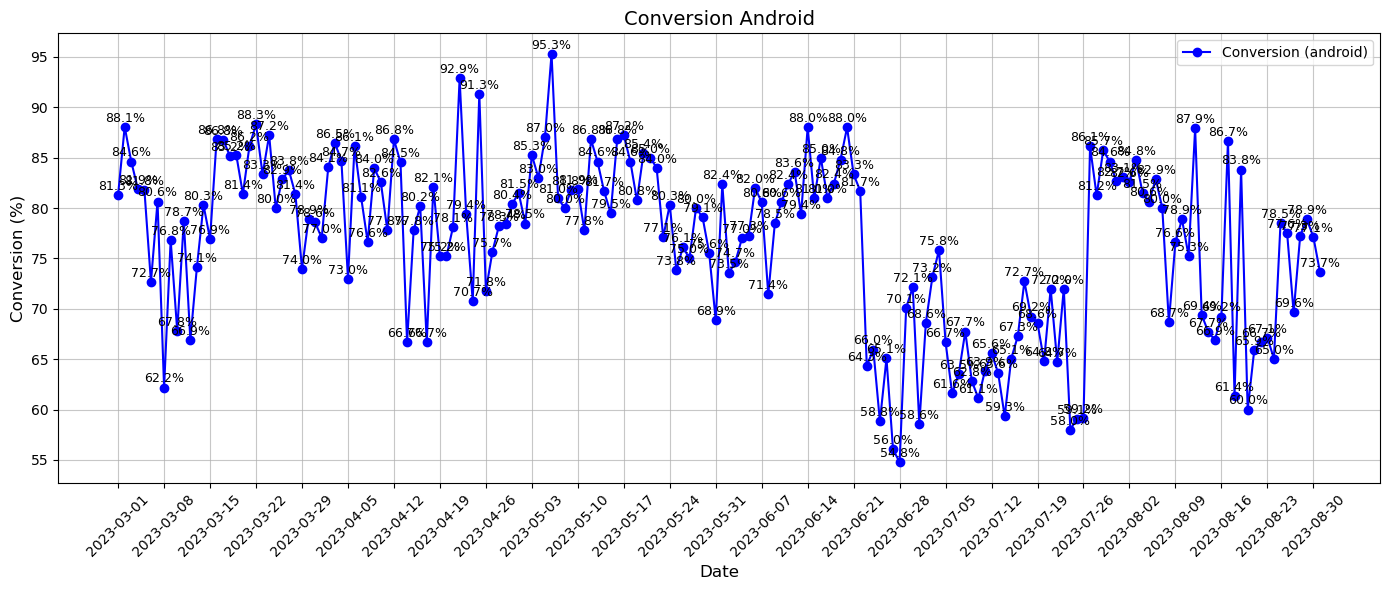

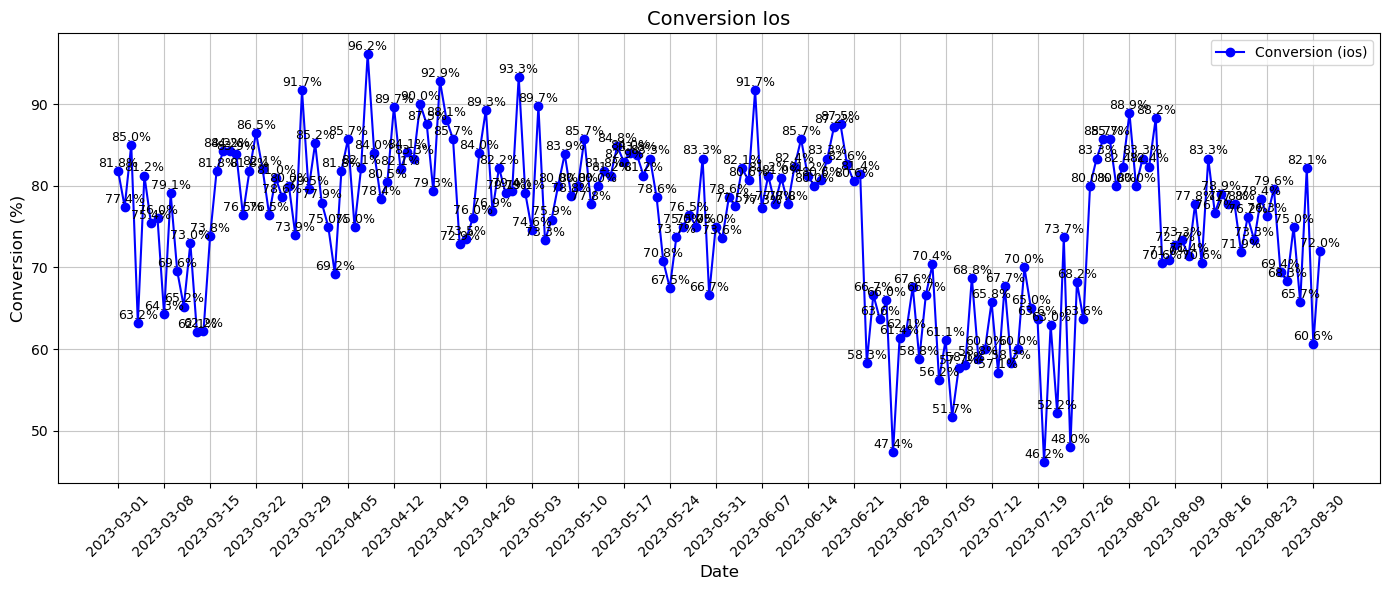

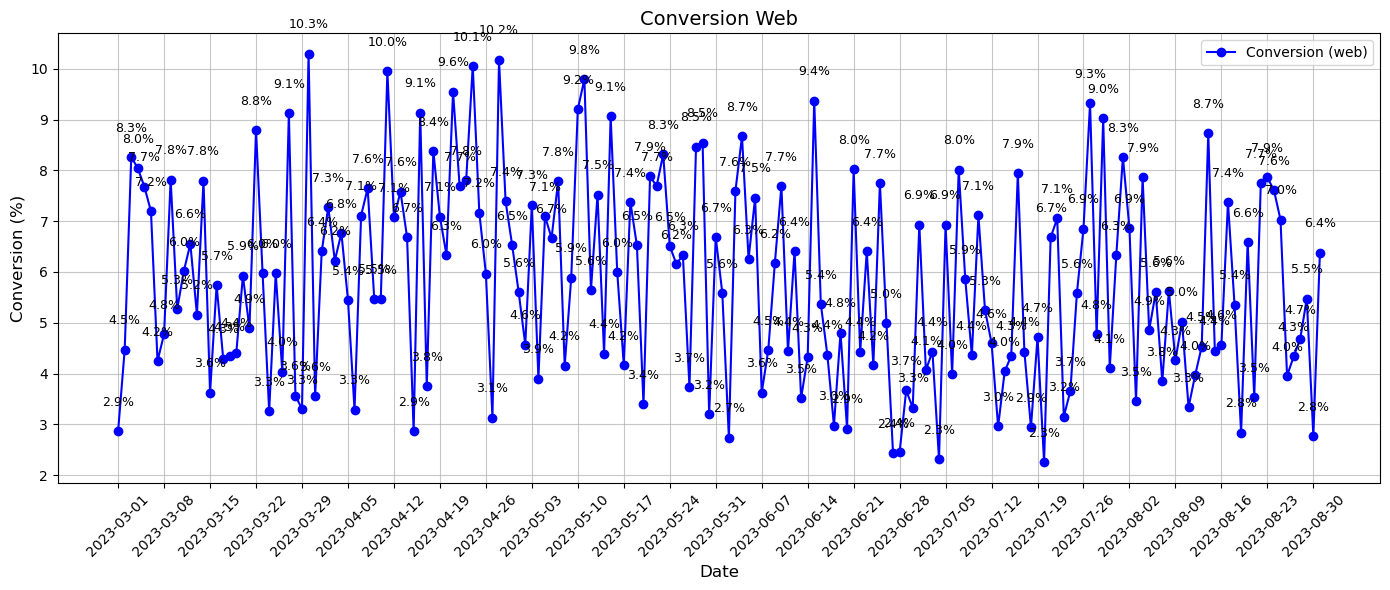

In [15]:
result_df_no_bot = result_df[result_df['platform'] != 'bot']

platforms_no_bot = result_df_no_bot['platform'].unique()

for platform in platforms_no_bot:
    platform_data = result_df_no_bot[result_df_no_bot['platform'] == platform]

    plt.figure(figsize=(14, 6))

    plt.plot(platform_data['date_group'], platform_data['conversion'], marker='o', color='blue', label=f'Conversion ({platform})')

    for x, y in zip(platform_data['date_group'], platform_data['conversion']):
        plt.text(x, y + 0.5, f"{y:.1f}%", ha='center', fontsize=9)

    weekly_ticks = pd.date_range(start='2023-03-01', end='2023-09-01', freq='7D')

    plt.title(f'Conversion {platform.capitalize()}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Conversion (%)', fontsize=12)
    plt.xticks(ticks=weekly_ticks, labels=weekly_ticks.strftime('%Y-%m-%d'), rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='both', linestyle='-', alpha=0.7)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig('./charts/conversion_by_platform.png', dpi=300, bbox_inches='tight')
    plt.show()

### Стоимости реклам

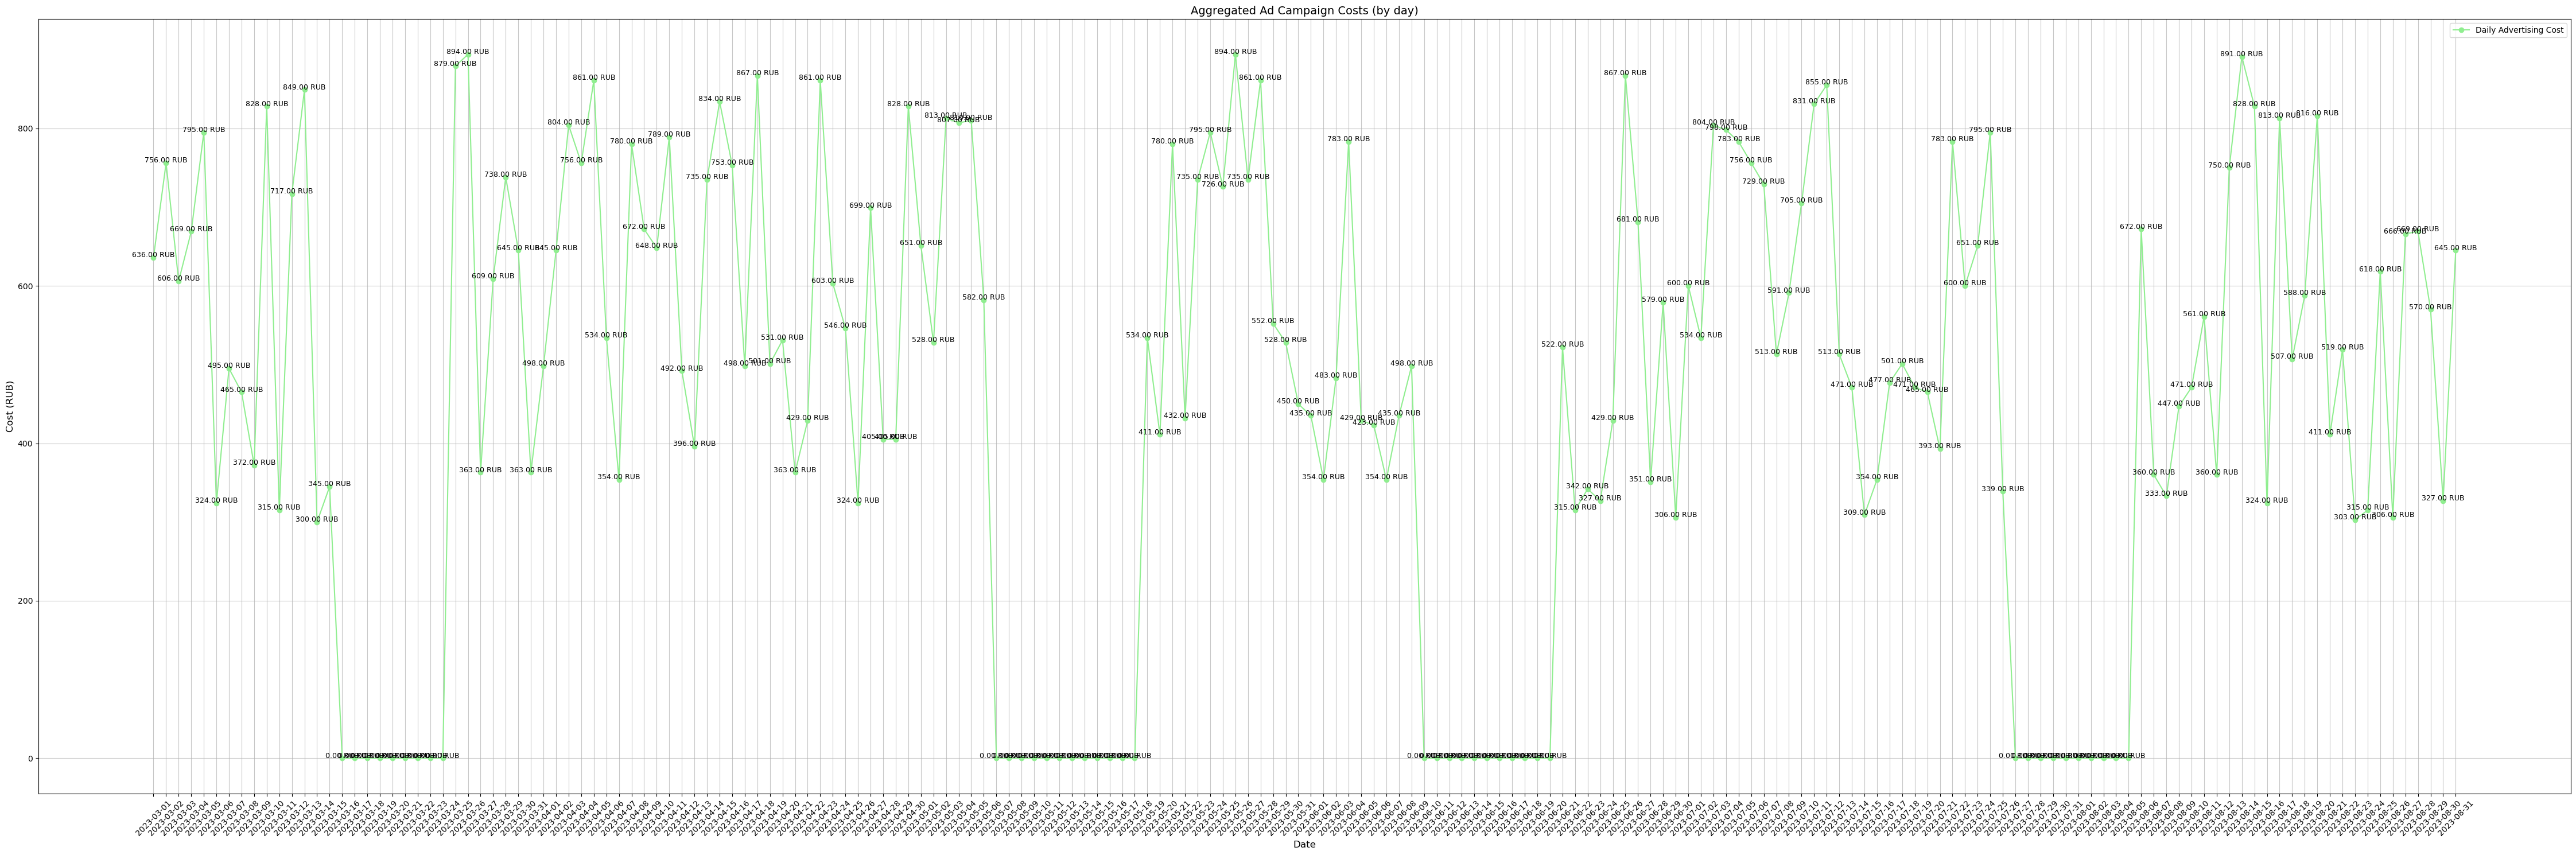

In [16]:
daily_cost = result_df.groupby('date_group')['cost'].sum().reset_index()

plt.figure(figsize=(45, 15))
plt.plot(daily_cost['date_group'], daily_cost['cost'], marker='o', color='lightgreen', label='Daily Advertising Cost')

for x, y in zip(daily_cost['date_group'], daily_cost['cost']):
    plt.text(x, y + 0.5, f"{y:.2f} RUB", ha='center', fontsize=9)

plt.title('Aggregated Ad Campaign Costs (by day)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cost (RUB)', fontsize=12)
plt.xticks(daily_cost['date_group'], daily_cost['date_group'].dt.strftime('%Y-%m-%d'), rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='-', alpha=0.7)
plt.legend(fontsize=10)

plt.grid(axis='x', linestyle='-', alpha=0.7)

plt.tight_layout()
plt.savefig('./charts/aggregated_ad_campaign_costs.png', dpi=300, bbox_inches='tight')
plt.show()

### Визиты и регистрации с выделением рекламных кампаний

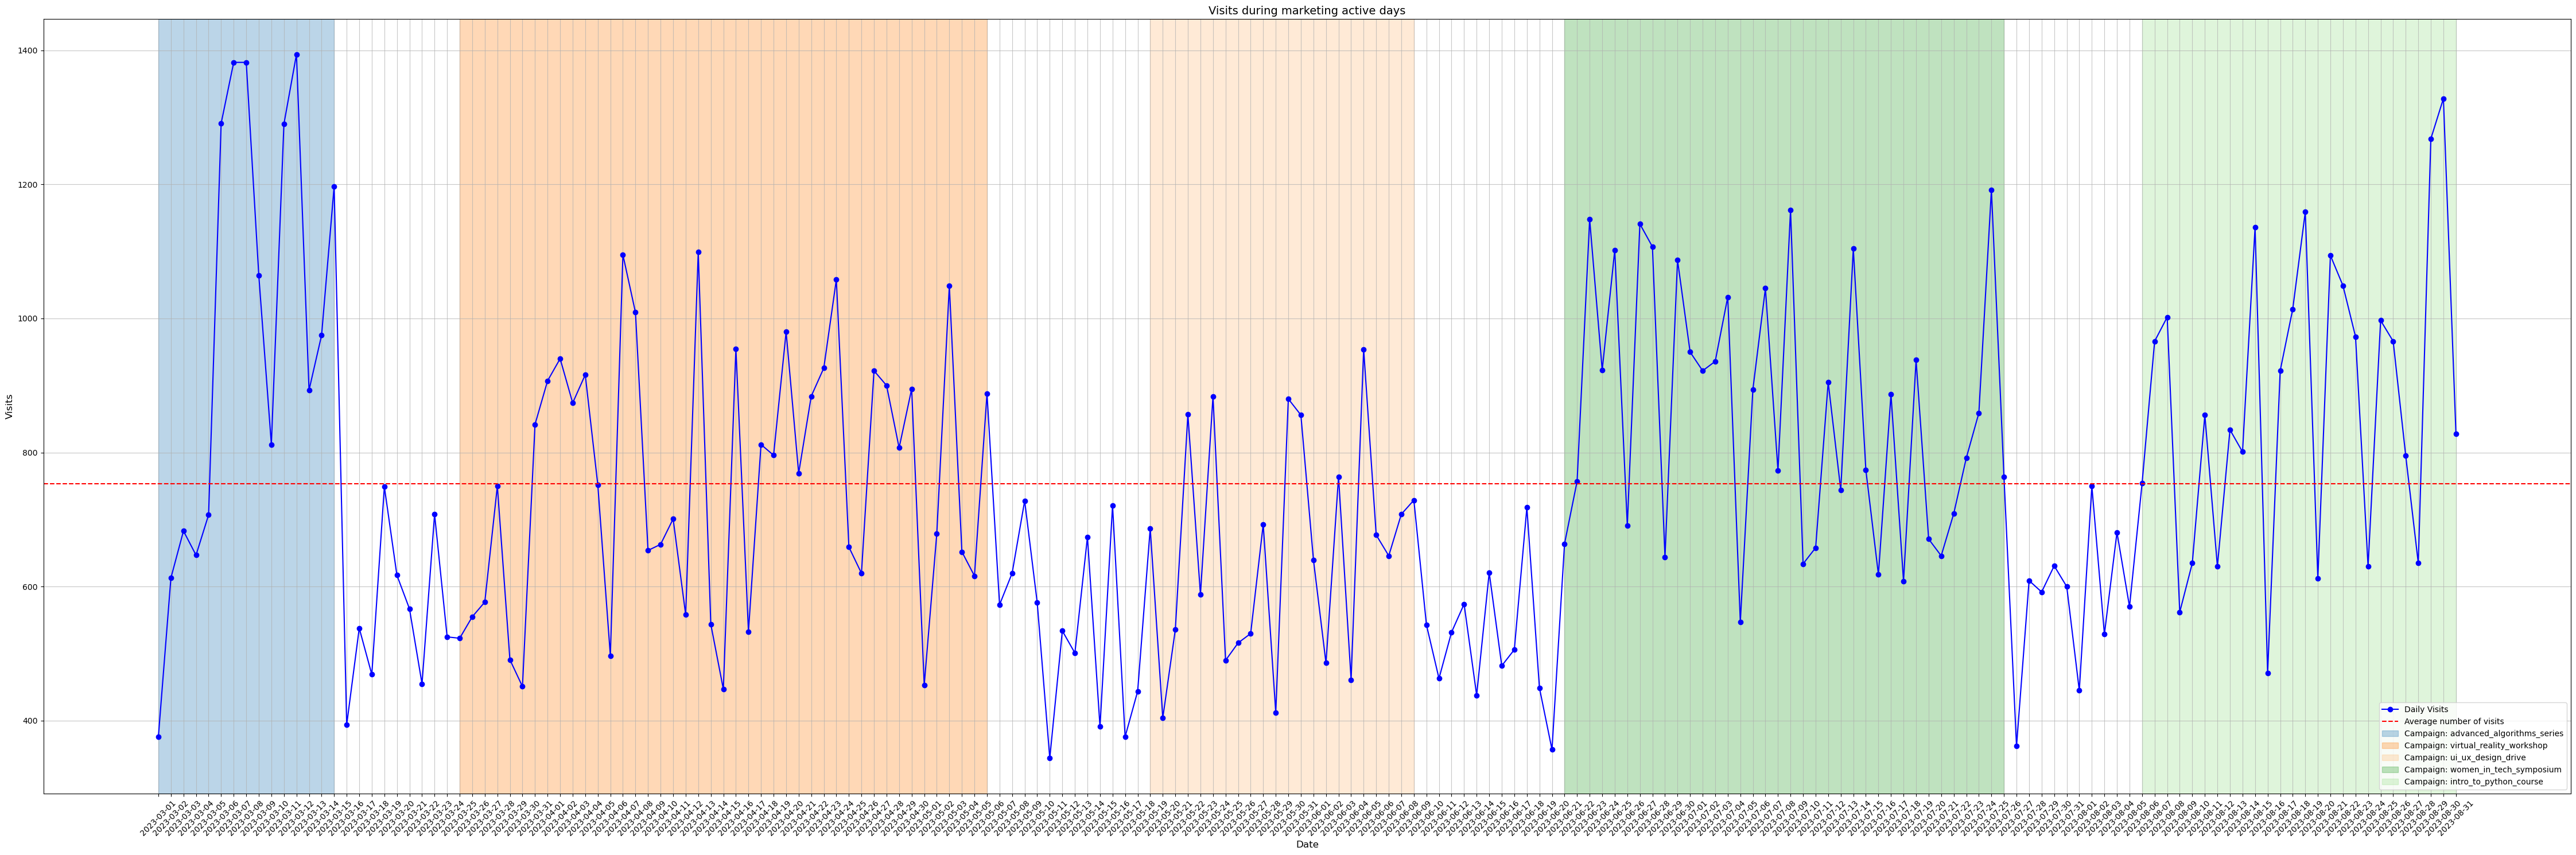

In [17]:
daily_visits = result_df.groupby('date_group')['visits'].sum().reset_index()

mean_visits = daily_visits['visits'].mean()

plt.figure(figsize=(45, 15))
plt.plot(daily_visits['date_group'], daily_visits['visits'], marker='o', color='blue', label='Daily Visits')

plt.axhline(mean_visits, color='red', linestyle='--', linewidth=1.5, label='Average number of visits')

campaigns = result_df['utm_campaign'].unique()
campaign_colors = {campaign: color for campaign, color in zip(campaigns, cm.tab20.colors)}

for campaign in campaigns:
    if campaign != 'none':
        campaign_data = result_df[result_df['utm_campaign'] == campaign]
        if not campaign_data.empty:
            start_date = campaign_data['date_group'].min()
            end_date = campaign_data['date_group'].max()
            plt.axvspan(
                start_date, end_date, alpha=0.3, 
                color=campaign_colors[campaign], label=f'Campaign: {campaign}'
            )

plt.title('Visits during marketing active days', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Visits', fontsize=12)
plt.xticks(daily_visits['date_group'], daily_visits['date_group'].dt.strftime('%Y-%m-%d'), rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='-', alpha=0.7)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('./charts/visits_during_marketing_active_days.png', dpi=300, bbox_inches='tight')
plt.show()

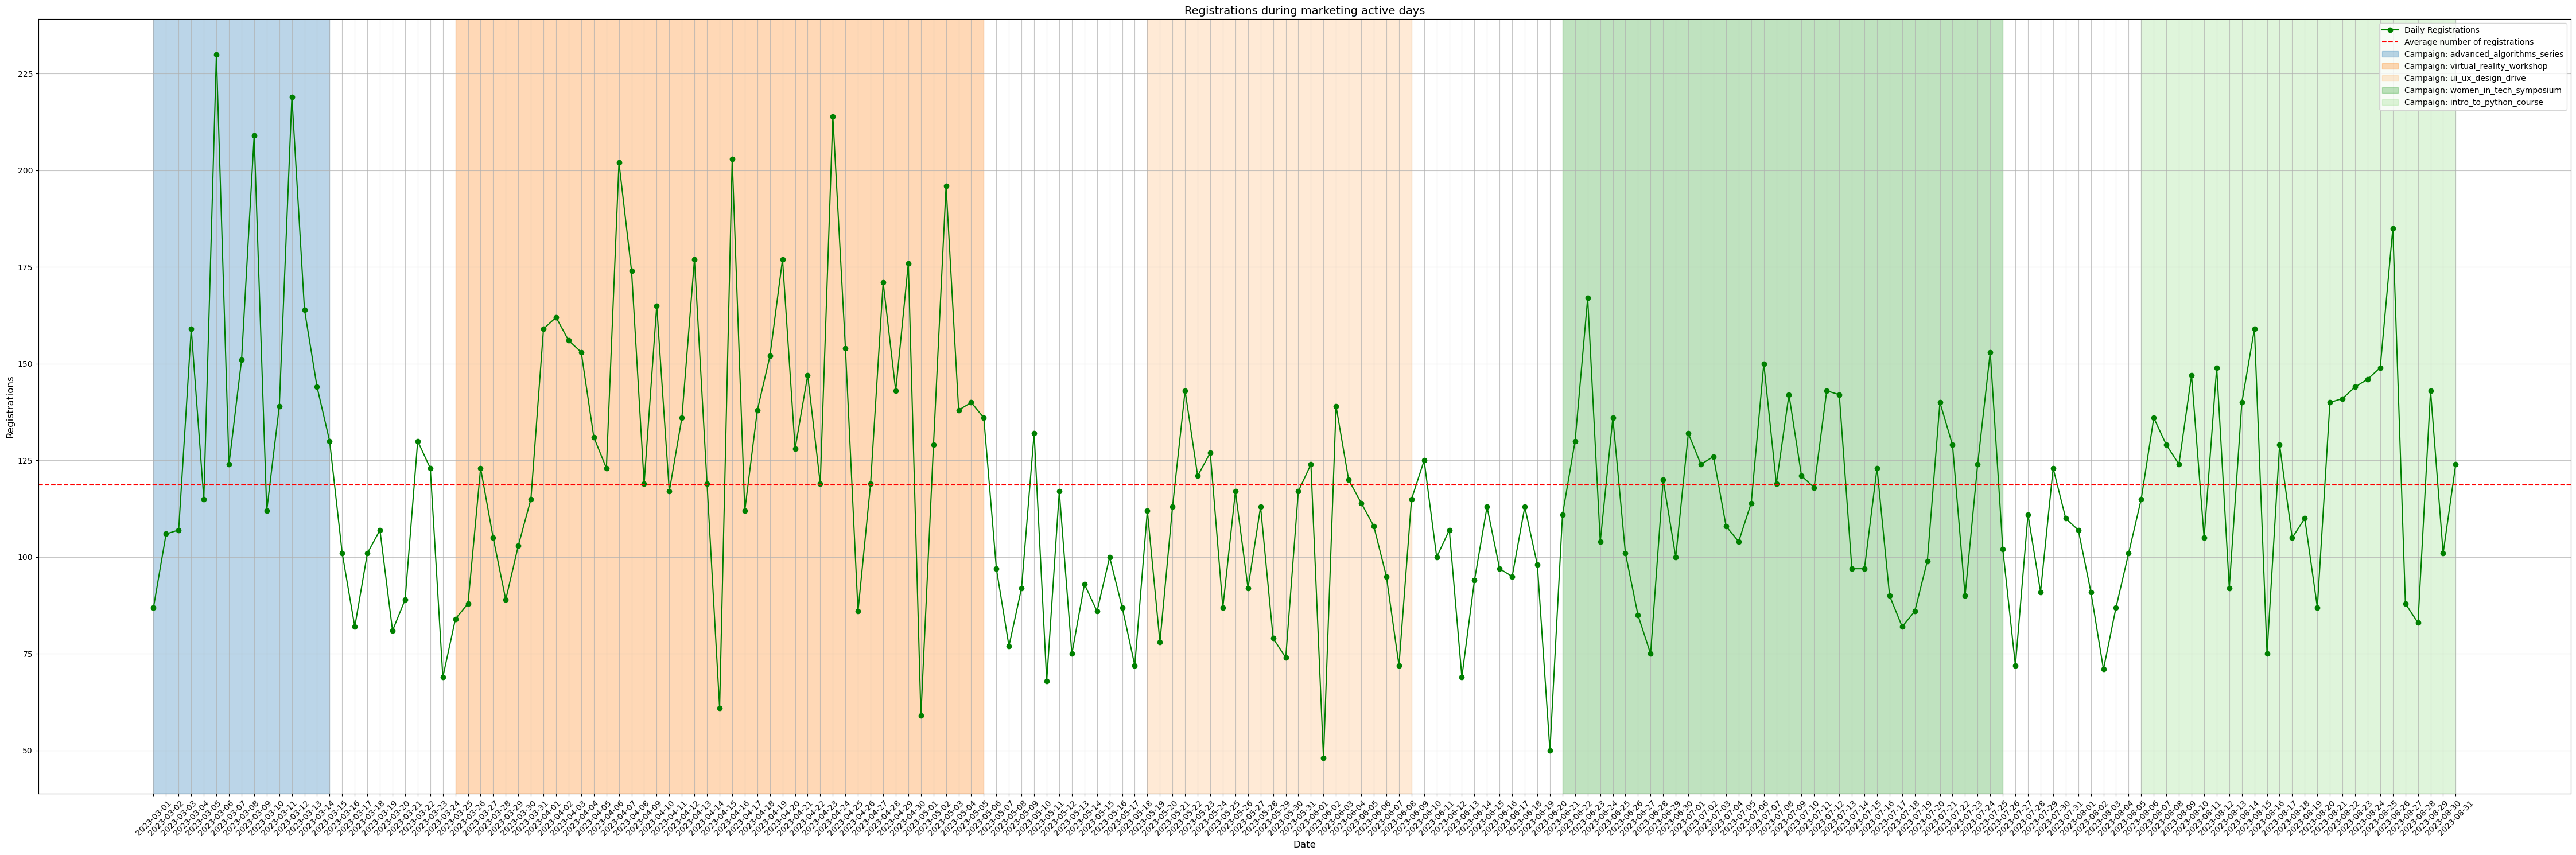

In [18]:
daily_registrations = result_df.groupby('date_group')['registrations'].sum().reset_index()

mean_registrations = daily_registrations['registrations'].mean()

plt.figure(figsize=(45, 15))
plt.plot(daily_registrations['date_group'], daily_registrations['registrations'], marker='o', color='green', label='Daily Registrations')

plt.axhline(mean_registrations, color='red', linestyle='--', linewidth=1.5, label='Average number of registrations')

campaigns = result_df['utm_campaign'].unique()
campaign_colors = {campaign: color for campaign, color in zip(campaigns, cm.tab20.colors)}

for campaign in campaigns:
    if campaign != 'none':
        campaign_data = result_df[result_df['utm_campaign'] == campaign]
        if not campaign_data.empty:
            start_date = campaign_data['date_group'].min()
            end_date = campaign_data['date_group'].max()
            plt.axvspan(
                start_date, end_date, alpha=0.3, 
                color=campaign_colors[campaign], label=f'Campaign: {campaign}'
            )

plt.title('Registrations during marketing active days', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Registrations', fontsize=12)
plt.xticks(daily_registrations['date_group'], daily_registrations['date_group'].dt.strftime('%Y-%m-%d'), rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='-', alpha=0.7)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('./charts/registrations_during_marketing_active_days.png', dpi=300, bbox_inches='tight')
plt.show()